In [1]:
import jax
import jax.random as random
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import DataLoader
import equinox as eqx
from jaxtyping import PRNGKeyArray, Float, Array, Int, PyTree
import jax.numpy as jnp
import numpy as np
import jaxtyping
import typeguard
import optax
from typing import Callable
from functools import partial

In [2]:
%load_ext jaxtyping
%jaxtyping.typechecker typeguard.typechecked

In [3]:
jax.devices()

[CudaDevice(id=0)]

In [4]:
BATCH_SIZE = 64
LEARNING_RATE = 6 * 10 ** -4  # 3e-4
EPOCHES = 450
PRINT_INTERVAL = 30
SEED = 4567
FloatScalar = Float[Array, ""]
key = random.PRNGKey(SEED)

2024-09-06 15:56:52.138610: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.5 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [5]:
normalize_data = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])
training_dataset = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=normalize_data
)
test_dataset = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=normalize_data
)


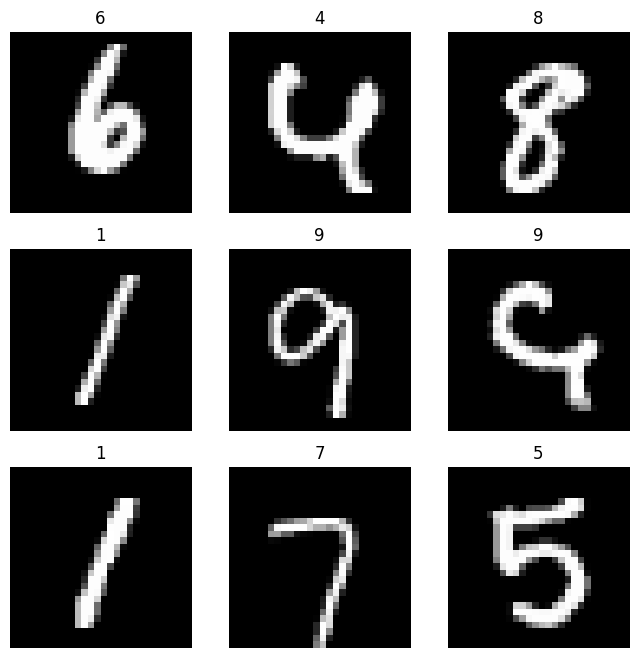

In [6]:
figure = plt.figure(figsize=(8, 8))
rows, column = 3, 3
for i in range(1, rows * column + 1):
    key, sample_key = random.split(key)
    sample_idx = int(random.randint(sample_key, shape=(1,), minval=0, maxval=len(training_dataset))[0])
    img: Image.Image
    label: str
    (img, label) = training_dataset[sample_idx]
    figure.add_subplot(rows, column, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [7]:
trainloader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
_x, _y = next(iter(trainloader))
_x, _y = _x.numpy(), _y.numpy()
print(f"x.shape: {_x.shape}")
print(f"y.shape: {_y.shape}")
print(f"y values: {set(map(int, set(_y)))}")

x.shape: (64, 1, 28, 28)
y.shape: (64,)
y values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [9]:
class CNN(eqx.Module):
    layers: list

    def __init__(self, key: PRNGKeyArray):
        key1, key2, key3, key4, key5 = random.split(key, 5)
        self.layers = [
            eqx.nn.Conv2d(1, 3, kernel_size=4, key=key1),
            eqx.nn.MaxPool2d(kernel_size=2),
            jax.nn.relu,
            jnp.ravel,
            eqx.nn.Linear(1728, 512, key=key3),
            jax.nn.relu,
            eqx.nn.Linear(512, 64, key=key4),
            jax.nn.relu,
            eqx.nn.Linear(64, 10, key=key4),
            jax.nn.log_sigmoid
        ]

    def __call__(self, x: Float[Array, "1 28 28"]) -> Float[Array, "10"]:
        for l in self.layers:
            x = l(x)
        return x

In [10]:
key, subkey = random.split(key)
model = CNN(subkey)
print(model)

CNN(
  layers=[
    Conv2d(
      num_spatial_dims=2,
      weight=f32[3,1,4,4],
      bias=f32[3,1,1],
      in_channels=1,
      out_channels=3,
      kernel_size=(4, 4),
      stride=(1, 1),
      padding=((0, 0), (0, 0)),
      dilation=(1, 1),
      groups=1,
      use_bias=True,
      padding_mode='ZEROS'
    ),
    MaxPool2d(
      init=-inf,
      operation=<function max>,
      num_spatial_dims=2,
      kernel_size=(2, 2),
      stride=(1, 1),
      padding=((0, 0), (0, 0)),
      use_ceil=False
    ),
    <wrapped function relu>,
    <wrapped function ravel>,
    Linear(
      weight=f32[512,1728],
      bias=f32[512],
      in_features=1728,
      out_features=512,
      use_bias=True
    ),
    <wrapped function relu>,
    Linear(
      weight=f32[64,512],
      bias=f32[64],
      in_features=512,
      out_features=64,
      use_bias=True
    ),
    <wrapped function relu>,
    Linear(
      weight=f32[10,64],
      bias=f32[10],
      in_features=64,
      out_features=1

In [11]:
@eqx.filter_jit
def loss(model: CNN, x: Float[Array, "batch 1 28 28"], y: Int[Array, "batch"]) -> FloatScalar:
    y_predict = jax.vmap(model)(x)
    return optax.losses.softmax_cross_entropy_with_integer_labels(y_predict, y).mean()

In [12]:
loss_value = loss(model, _x, _y)
print(f"loss value: {loss_value}")
output = jax.vmap(model)(_x)
print(f"output.shape: {output.shape}")

loss value: 2.3057570457458496
output.shape: (64, 10)


In [13]:
@eqx.filter_jit
def accuracy(model: CNN, x: Float[Array, "batch 1 28 28"], y: Int[Array, "batch"]) -> FloatScalar:
    y_predict = jax.vmap(model)(x)
    y_predict = jnp.argmax(y_predict, axis=1)
    return jnp.mean(y_predict == y)


def evaluation(model: CNN, testloader: DataLoader) -> tuple[FloatScalar, FloatScalar]:
    avg_loss = 0
    avg_accuracy = 0
    for x, y in testloader:
        x, y = x.numpy(), y.numpy()
        avg_loss += loss(model, x, y)
        avg_accuracy += accuracy(model, x, y)
    return avg_loss / len(testloader), avg_accuracy / len(testloader)

In [14]:
evaluation(model, testloader)

(Array(2.3016832, dtype=float32), Array(0.12888137, dtype=float32))

In [15]:
optimizer = optax.adamw(LEARNING_RATE)
train_history = []
test_history = []


@eqx.filter_jit
def train_step(model: CNN, opt_state: PyTree, x: Float[Array, "batch 1 28 28"], y: Int[Array, "batch"]) -> tuple[
    CNN, PyTree, FloatScalar]:
    loss_value: FloatScalar
    grad: Callable
    loss_value, grad = eqx.filter_value_and_grad(loss)(model, x, y)
    updates, opt_state = optimizer.update(grad, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss_value


def train(model: CNN, trainloader: DataLoader, testloader: DataLoader, optim: optax.GradientTransformation,
          epoches: int, print_interval: int) -> CNN:
    opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

    def infinite_trainloader():
        while True:
            yield from trainloader

    for epoch, (x, y) in zip(range(epoches), infinite_trainloader()):
        x, y = x.numpy(), y.numpy()
        x: np.ndarray
        y: np.ndarray
        model, opt_state, train_loss = train_step(model, opt_state, x, y)
        if (epoch % print_interval) == 0 or (epoch == epoches - 1):
            train_loss, train_accuracy = evaluation(model, trainloader)
            print(
                f"Epoch {epoch} loss: {train_loss} accuracy: {train_accuracy}"
            )
            test_loss, test_accuracy = evaluation(model, testloader)
            train_history.append(train_loss)
            test_history.append(test_loss)
    return model

In [16]:
model = train(model, trainloader, testloader, optimizer, EPOCHES, PRINT_INTERVAL)

Epoch 0 loss: 2.2882139682769775 accuracy: 0.1819196492433548
Epoch 30 loss: 0.9872490763664246 accuracy: 0.7259628176689148
Epoch 60 loss: 0.556846022605896 accuracy: 0.8357709646224976
Epoch 90 loss: 0.4739975035190582 accuracy: 0.8483642339706421
Epoch 120 loss: 0.47045162320137024 accuracy: 0.8602412343025208
Epoch 150 loss: 0.3478374183177948 accuracy: 0.8983542323112488
Epoch 180 loss: 0.33852675557136536 accuracy: 0.9009361863136292
Epoch 210 loss: 0.341585248708725 accuracy: 0.8995702266693115
Epoch 240 loss: 0.33187657594680786 accuracy: 0.9061000943183899
Epoch 270 loss: 0.283145010471344 accuracy: 0.9155950546264648
Epoch 300 loss: 0.2890709638595581 accuracy: 0.9100646376609802
Epoch 330 loss: 0.2543315291404724 accuracy: 0.9262393712997437
Epoch 360 loss: 0.2514239251613617 accuracy: 0.9265891909599304
Epoch 390 loss: 0.23799782991409302 accuracy: 0.9297041893005371
Epoch 420 loss: 0.23901040852069855 accuracy: 0.9281550049781799
Epoch 449 loss: 0.2941831052303314 accuracy

In [17]:
evaluation(model, testloader)

(Array(0.28650647, dtype=float32), Array(0.91948646, dtype=float32))

In [18]:
my_handwriting = Image.open("my-handwriting/misleading_6.png").convert("L")
my_handwriting = np.array(my_handwriting)
my_handwriting = normalize_data(my_handwriting)
my_handwriting: torch.Tensor
my_handwriting.shape

torch.Size([1, 28, 28])

In [19]:
prediction = model(jnp.array(my_handwriting))
predicted_class = jnp.argmax(prediction)

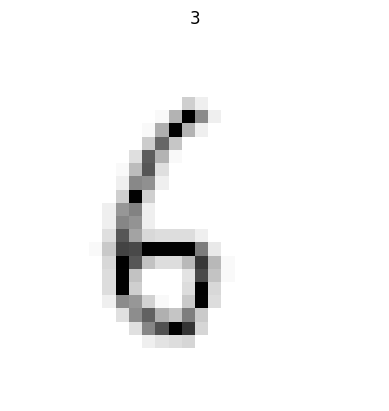

In [20]:
plt.title(predicted_class)
plt.axis("off")
_ = plt.imshow(my_handwriting.squeeze(), cmap="gray")

[-10.6293     -13.358962    -7.7851524  -11.3088665   -8.777529
  -7.896103    -0.75967455 -16.966934   -10.552841   -15.154986  ]
[ -0.20106637 -18.058578    -9.989372   -11.100574   -17.61243
  -4.142379   -10.750277   -16.641401    -9.80455    -16.586369  ]
[-12.9053755 -17.81417   -12.480833  -11.6695     -1.1434015  -9.167398
  -9.396741   -8.739649  -11.775618   -8.510422 ]
[ -8.568826   -9.603228   -7.1612916  -6.5511265 -17.04747    -6.414368
 -11.943375  -13.643073   -6.302095  -12.794846 ]
[-10.007201 -15.116169 -10.554882  -9.579443 -12.035221  -5.463549
  -2.851194 -21.280432  -8.825839 -16.964602]
[-14.147155  -11.504467  -14.300132   -6.7787256  -7.2653065  -6.563489
 -13.461773   -8.151671   -7.3063354  -4.583295 ]
[ -5.868379  -17.806858  -10.447578  -12.585319   -9.051467   -6.9581842
  -1.1290879 -16.266567  -13.751638  -15.036534 ]
[-14.271669   -8.891445   -1.6065333  -4.480253  -15.36396    -9.693755
 -10.464786  -10.238886   -9.105764  -13.706759 ]
[ -1.2290874 -1

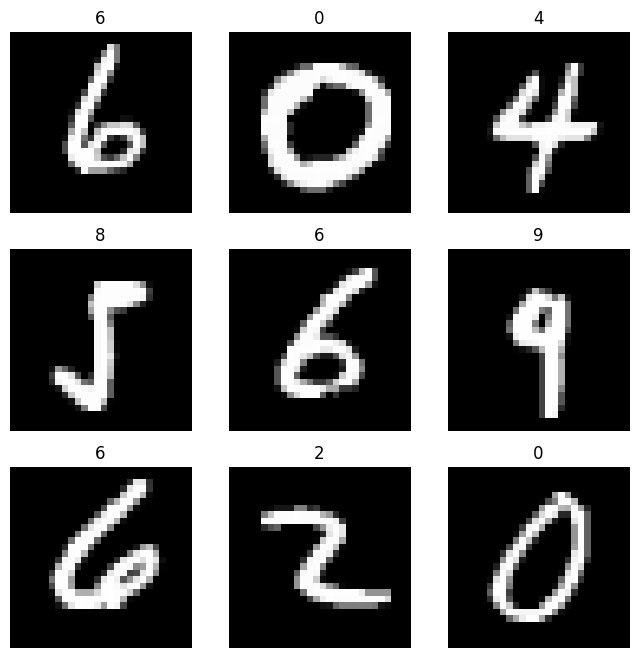

In [25]:
figure = plt.figure(figsize=(8, 8))
rows, column = 3, 3
for i in range(1, rows * column + 1):
    key, sample_key = random.split(key)
    sample_idx = int(random.randint(sample_key, shape=(1,), minval=0, maxval=len(training_dataset))[0])
    img: Image.Image
    label: str
    (img, label) = training_dataset[sample_idx]
    figure.add_subplot(rows, column, i)
    plt.title(str(jnp.argmax(model(jnp.array(img)))))
    print(model(jnp.array(img)))
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

plt.show()

In [22]:
prediction = model(jnp.array(my_handwriting))

In [23]:
jnp.argmax(prediction)

Array(3, dtype=int32)

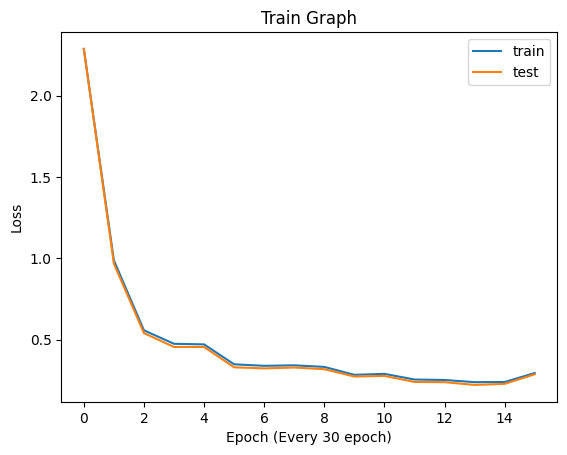

In [24]:
plt.title("Train Graph")
plt.plot(train_history, label="train")
plt.plot(test_history, label="test")
plt.xlabel(f"Epoch (Every {PRINT_INTERVAL} epoch)")
plt.ylabel("Loss")
plt.legend()
plt.show()